## Quantum Annealing using Qamomile and QuTip

From here, we will introduce applications in quantum annealing using Qamomile and QuTip. We focus on a Hamiltonian of the following form:

$$
H(s) = s H_0 + (1 - s) H_1
$$

where $ H_0 $ is the Hamiltonian for the Max-Cut problem we want to solve and often formulated in terms of an Ising model, and $ H_1 $ is the Hamiltonian for the transverse magnetic field. For further details on how to construct the Hamiltonian for the max-cut problem, please refer to [QAOA for Max-Cut](https://jij-inc.github.io/Qamomile/tutorial/maxcut.html).
The Hamiltonians are defined as follows: $$
H_0 = -\frac{1}{2} \sum_{(i,j) \in E} w_{i,j}(1 - s_i s_j)  , \quad H_1 = - \sum_{i=1}^N \sigma_i^x
$$


As the parameter $s$ gradually shifts from 0 to 1, the system gradually evolves from the ground state of $H_1$ to the ground state of  $H_0$, which corresponds to the solution to the optimization problem. 

Quantum annealing relies on quantum tunneling to allow the system to escape local minima by passing through energy barriers, rather than needing to climb over them as in classical annealing.

First, let’s import the Qamomile library and other libraries used in this example.


In [1]:
import jijmodeling as jm
import numpy as np
import qamomile.core.operator as qm_o
import matplotlib.pyplot as plt
import qamomile.qutip as qm_qt

def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    w = jm.Placeholder("w", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)

    problem = jm.Problem("Maxcut")
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = -1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem


problem = Maxcut_problem()
problem

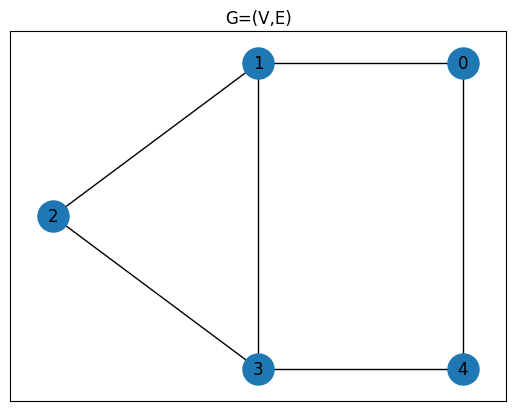

In [2]:
import networkx as nx
from IPython.display import display, Latex

G = nx.Graph()
num_nodes = 5
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
plt.title("G=(V,E)")
plt.plot(figsize=(5, 4))

nx.draw_networkx(G, pos, node_size=500)

In [3]:
import jijmodeling_transpiler.core as jmt
compiled_model = jmt.compile_model(problem, {"V": num_nodes, "E": edges})

In [4]:
import qamomile.core as qm

# Obtain cost hamiltonian
qaoa_converter = qm.qaoa.QAOAConverter(compiled_model)
H0 = qaoa_converter.get_cost_hamiltonian()

Now transpile the qamomile’s hamiltonian to the qutip’s hamiltonian

In [5]:
qt_transpiler = qm_qt.QuTiPTranspiler()
qt_H0= qt_transpiler.transpile_hamiltonian(H0)

Hamiltonian $H_1$ for the transverse magnetic field is also needed to be constructed

In [6]:
H1 = qm_o.Hamiltonian()
for q1 in range(num_nodes):
    H1 -= qm_o.X(q1)
qt_H1= qt_transpiler.transpile_hamiltonian(H1)

We define the annealing time $T$ with $s = t / T$, where s is the parameter in the Hamiltonian $H(s)$ introduced earlier. In Quantum Annealing, if $T$ is taken sufficiently large, the ground state of $H_0$ can theoretically be obtained with 100\% probability. We perform quantum annealing for the Max-Cut problem and examine whether the final state $|\psi(T)\rangle$ is an optimal solution to the problem.

The entire Hamiltonian of the quantum annealing is given as a list where each element is a pair consisting of a Hamiltonian and its coefficient. Also, We create the initial state $ \psi(t)$ at $t = 0$, which is the ground state of $H_1$.

In [7]:
from qutip import tensor, Qobj, mesolve

def coef0(t, args):
    return t/T

def coef1(t, args):
    return 1-t/T

H = [[qt_H0, coef0], [qt_H1, coef1]]
psi0 = tensor([Qobj([[1], [1]])/np.sqrt(2) for i in range(num_nodes)])

To solve the Schrödinger equation, we use `mesolve`with the Hamiltonian, the initial state and a list of times.

In [8]:
T=100
tlist = np.linspace(0.0, T, 101)
result = mesolve(H, psi0, tlist, [])
psi_final = result.states[-1]

We can visualize the probability distribution of the final state after annealing.

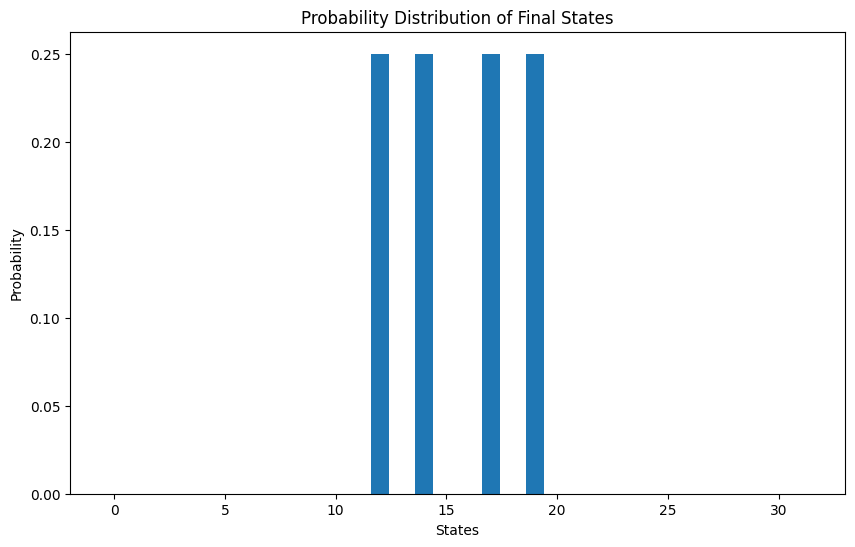

In [23]:
probs = np.abs(psi_final.full())**2
plt.figure(figsize=(10, 6))
basis_labels = [f"{i:0{num_nodes}b}" for i in range(2**num_nodes)]
bars=plt.bar(range(len(probs)), probs.flatten())
plt.xlabel("States")
plt.ylabel("Probability")
plt.title("Probability Distribution of Final States")

plt.show()

The final states and their corresponding probabilities are:

In [10]:
final_states = []
for bar, label in zip(bars, basis_labels):
    if bar.get_height() > 1e-4:
        print(f"Final state: {label}, Probability: {bar.get_height():.4f}")
        array_label = np.array([int(bit) for bit in label])
        final_states.append((array_label, bar.get_height())) 

Final state: 01100, Probability: 0.2500
Final state: 01110, Probability: 0.2500
Final state: 10001, Probability: 0.2500
Final state: 10011, Probability: 0.2500


According to the result, there are four degenerate solutions. Let's visualize all the solutions. Meanswhile, we can refer to the result obtained using [QAOA](https://jij-inc.github.io/Qamomile/tutorial/maxcut.html)

In [11]:
from qamomile.core.bitssample import BitsSample, BitsSampleSet
samples = []
for state,prob in final_states:
    sample = BitsSample(int(prob), state)
    samples.append(sample)

sample_set = BitsSampleSet(bitarrays=samples)

transformed_state = []
for transformed in qaoa_converter.decode_bits_to_sampleset(sample_set).data:
    transformed_state.append(transformed.var_values['x'].values)

In [12]:
transformed_state

[{(4,): 1.0, (1,): 1.0},
 {(2,): 1.0, (1,): 1.0, (4,): 1.0},
 {(3,): 1.0, (0,): 1.0},
 {(0,): 1.0, (2,): 1.0, (3,): 1.0}]

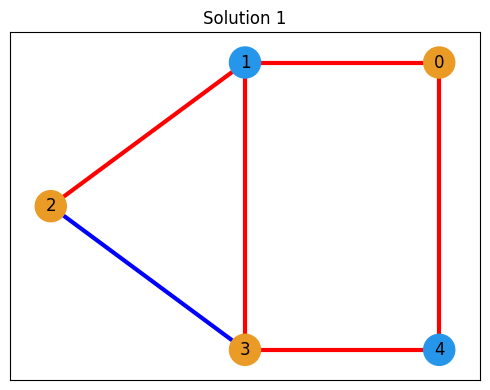

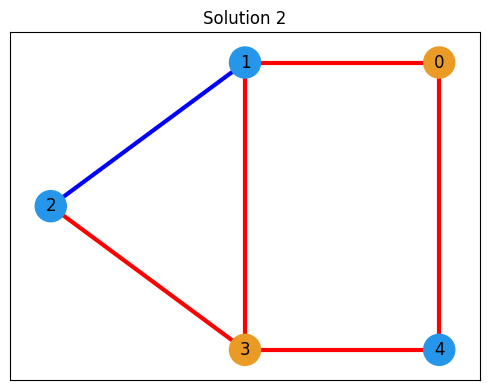

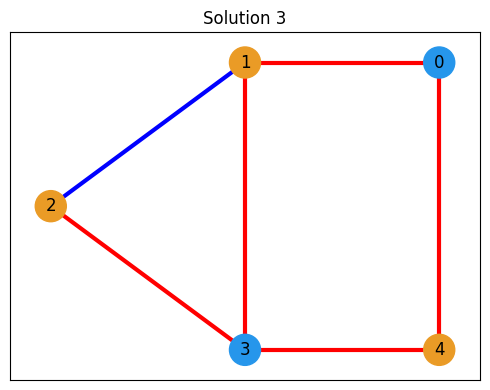

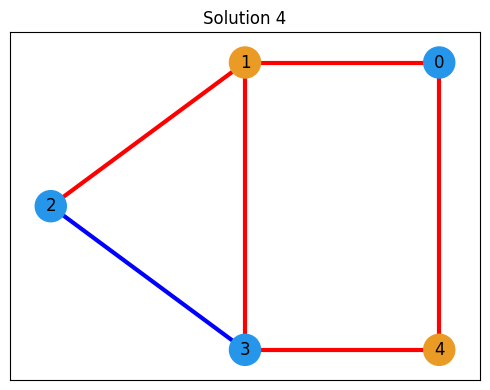

In [13]:
edge_colors = []

def get_edge_colors(graph, cut_solution, in_cut_color="r", not_in_cut_color="b"):
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
            
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9B26" for node in graph.nodes()]
    return edge_colors, node_colors


for i, cut_solution in enumerate(transformed_state):
    
    edge_colors, node_colors = get_edge_colors(G, cut_solution)

    # Create the plot
    plt.figure(figsize=(5, 4))
    plt.title(f"Solution {i+1}")

    nx.draw_networkx(
        G,
        pos,
        node_size=500,
        width=3,
        with_labels=True,
        edge_color=edge_colors,
        node_color=node_colors,
    )

    plt.tight_layout()
    plt.show()

We can also visualize how the eigenenergy of the Hamiltonian changes as the parameter $s$ varies from 0 to 1 on the energy spectrum calculated by `eigenenergies`. 

In [20]:
slist = np.linspace(0.0, 1.0, 101)
enegry_list = [[] for i in range(2**num_nodes)]

for s in slist:
    qt_H = s*qt_H0 + (1-s)*qt_H1
    enegry = qt_H.eigenenergies()
    for i in range(2**num_nodes):
        enegry_list[i].append(enegry[i])

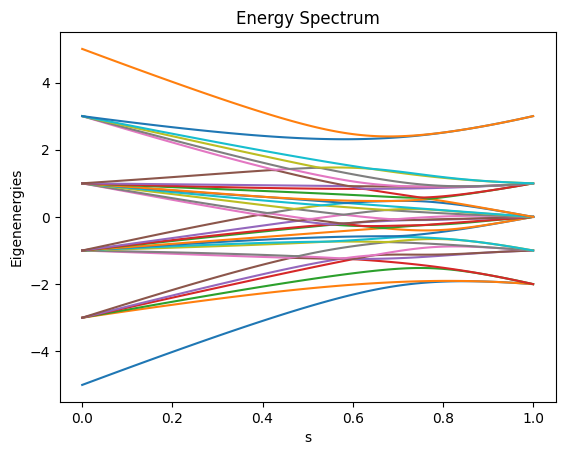

In [21]:
for i in range(2**num_nodes):
    plt.plot(slist, enegry_list[i], label=f"{i+1}th")

plt.xlabel("s")
plt.ylabel("Eigenenergies")
plt.title("Energy Spectrum")
plt.show()

We can see that there are four degenerate states that share the same lowest energy level, which agrees with the annealing result.

Masaphys. *PythonとQuTiPで量子アニーリングのダイナミクスを追う*. Qiita. Accessed October 30, 2024. [https://qiita.com/masaphys/items/38aeaee5313f81e15414](https://qiita.com/masaphys/items/38aeaee5313f81e15414)
